## Importações e configurações do ambiente

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
%config InlineBackend.figure_format = 'retina'

## Sintetizando *dataset*

Dados sobre as variáveis independentes.

In [2]:
np.random.seed(42)
n = 200

# Variáveis independentes
X1 = np.random.uniform(0, 10, n)
X2 = np.random.normal(4, 2, n)
X3 = X1 + np.random.normal(0, 0.5, n)    # Correlacionado com X1, mas não diretamente com y

* Modelo linear populacional
$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \varepsilon
$$

> Repare que $X_3$ não está relacionado com $y$

In [3]:
# Parâmetros do modelo linear real (população)
b0 = 5
b1 = 2
b2 = -1.5

# Erro normalmente distribuido
desvio_erro = 3
erro = np.random.normal(0, desvio_erro, n)

$$
y = 5 + 2X_1 - 1.5X_2 + \varepsilon
$$

Onde:
* $\varepsilon \thicksim \mathcal{N}(0,3)$

In [4]:
y = b0 + b1 * X1 + b2 * X2 + erro

Organizando as observações num dataframe para facilitar

In [5]:
# Criando um DataFrame para o dataset
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
        'y': y
})

## Análise de correlação

A partir de agora, iremos "esquecer" que os dados utilizados foram gerados artificialmente (i.e., suas distribuições e relações são conhecidas). Sendo assim, a primeira análise a se fazer seria identificar quais variáveis estão correlacionadas com o alvo

In [6]:
data.corr()['y'][:-1]

X1    0.810298
X2   -0.440034
X3    0.810195
Name: y, dtype: float64

A tabela acima sugere que $X_2$ está moderadamente associada a variável $y$, enquanto as demais estão fortemente associadas. Vamos explorar essa associação num gráfico de dispersão

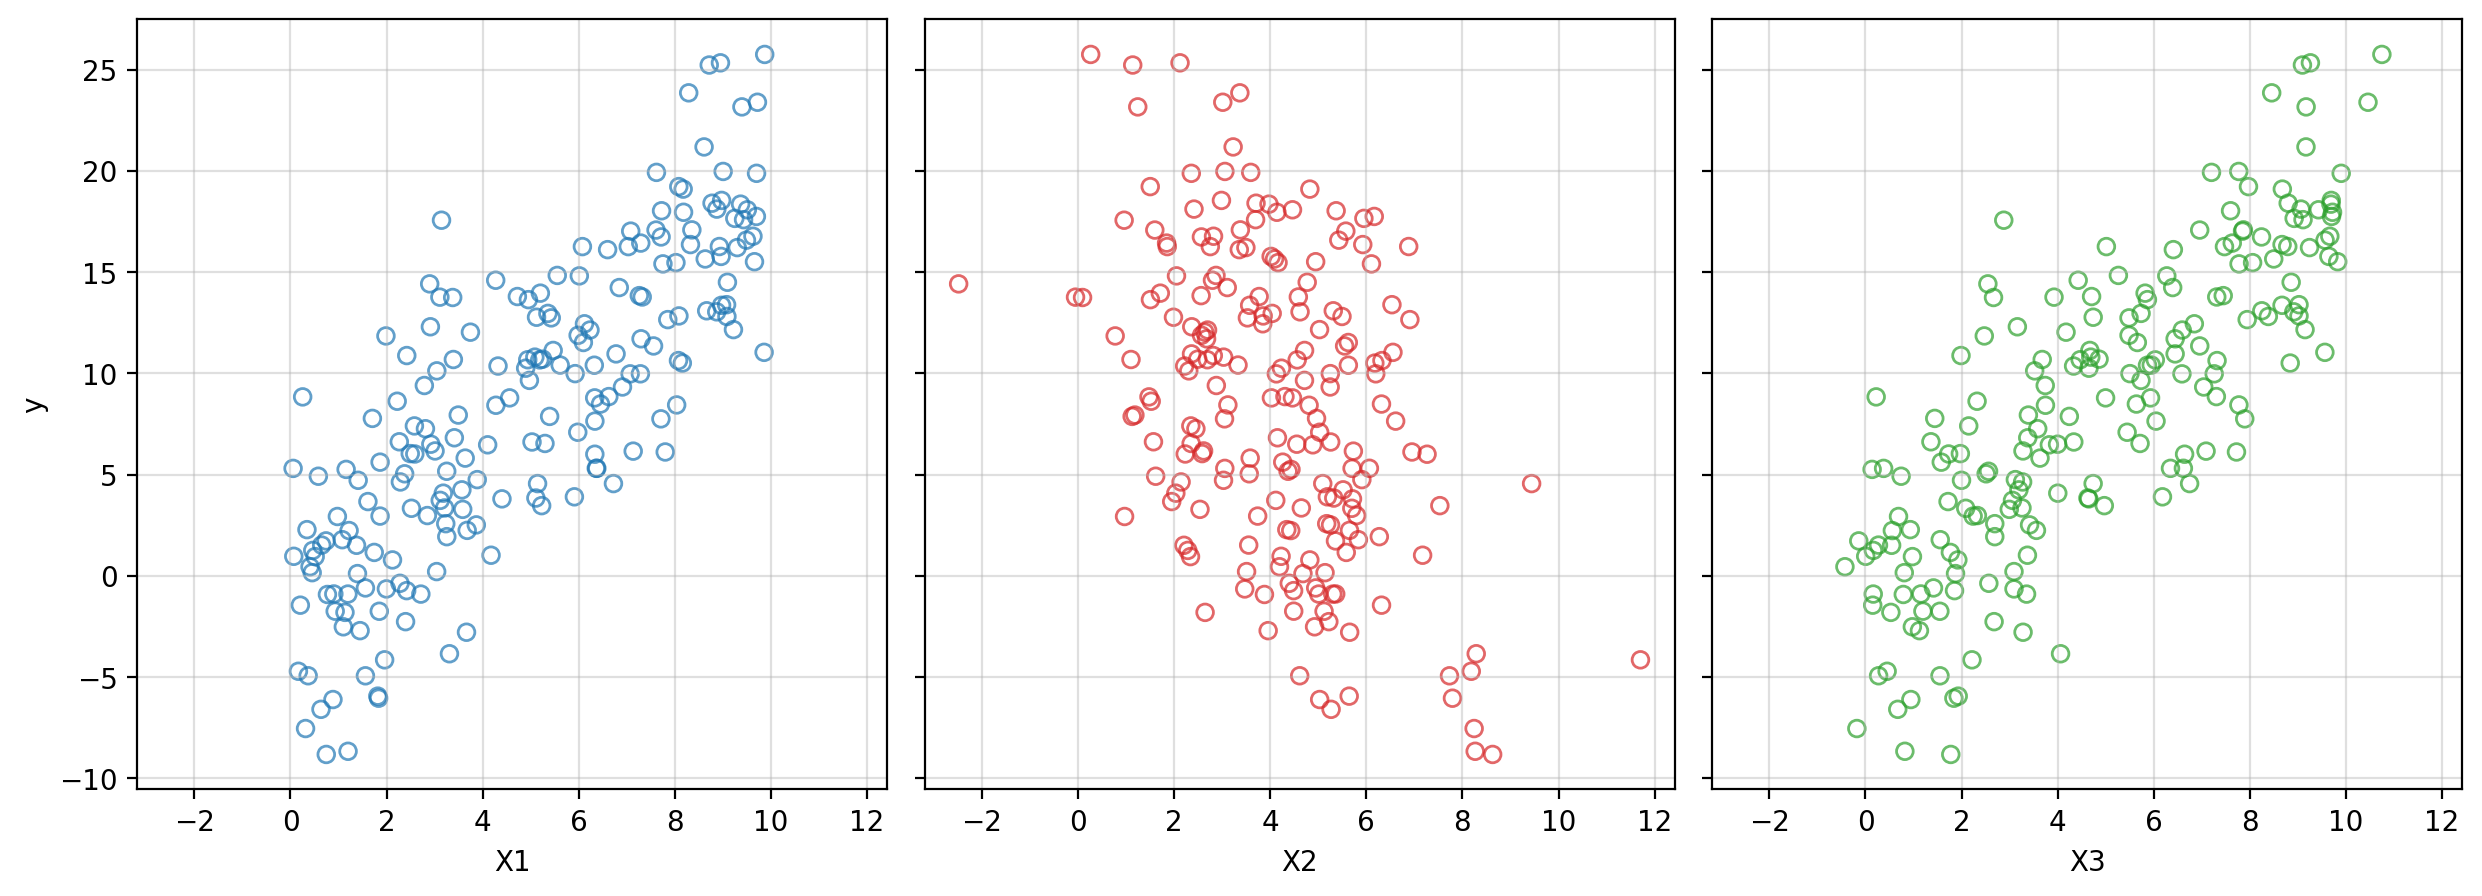

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15, 5),sharey=True,sharex=True,gridspec_kw={'wspace':0.05})
cores = ['tab:blue','tab:red','tab:green']

for i,(preditor,cor) in enumerate(zip(data.iloc[:,:-1],cores)):
    axs[i].scatter(data[preditor], data['y'], alpha=0.7, edgecolor=cor, color='None')
    axs[i].set_xlabel(preditor)
    axs[i].grid(alpha=0.4)
    
axs[0].set_ylabel('y')
plt.show()

## Regressão linear simples

In [8]:
# Parte 2: Regressões lineares simples
estatisticas_estimadores_consolidado = []
estatisticas_modelo_consolidado = []

for preditor in data.iloc[:,:-1]:
    
    X_vies = sm.add_constant(data[preditor])  # Adicionando intercepto
    modelo = sm.OLS(data['y'], X_vies).fit()
    
    estatisticas_estimadores = {
        'Estimador': preditor,
        'Coeficiente': modelo.params[preditor],
        'SE': modelo.bse[preditor],
        't-statistic': modelo.tvalues[preditor],
        'p-value': modelo.pvalues[preditor]}
     
    estatisticas_modelo = {   
        'Preditor': preditor,
        'R2' : modelo.rsquared,
        'RSE': np.sqrt(modelo.mse_resid)}
    
    estatisticas_estimadores_consolidado.append(estatisticas_estimadores)
    estatisticas_modelo_consolidado.append(estatisticas_modelo)

### Análise dos estimadores na regressão simples

Ajustando as tabelas que contém as estatísticas dos estimadores e dos modelos considerados

In [9]:
# Dataframe com as estatísticas dos estimadores
estimadores_regressao_simples = pd.DataFrame(estatisticas_estimadores_consolidado)
estimadores_regressao_simples.set_index('Estimador',inplace=True)

In [10]:
estimadores_regressao_simples

,Coeficiente,SE,t-statistic,p-value
Estimador,,,,
X1,2.041181,0.104910,19.456574,7.756436e-48
X2,-1.686596,0.244602,-6.895272,7.044788e-11
X3,1.995852,0.102618,19.449348,8.141178e-48


Agora vamos comparar os resultados da tabela acima com os dados (conhecidos) da população, lembrando que:

$$
y = 5 + 2X_1 - 1.5X_2 + \varepsilon \qquad \equiv \qquad y = 5 + 2X_1 - 1.5X_2 + 0X_3 + \varepsilon 
$$

* $\beta_1  = 2 \Longrightarrow \hat\beta_1 = 2.04$
* $\beta_2  = -1.5 \Longrightarrow \hat\beta_2 = -1.68$
* $\beta_3  = 0 \Longrightarrow \hat\beta_3 = 1.99$

O erro cometido nas estimativas para $\beta_1$ e $\beta_2$ são pequenos, enquanto o coeficiente de $\beta_3$ fora estimado muito erroneamente. Veja que se fóssemos nos basear somente nos *p-values* para avaliar a significância estatística dos coeficientes, estaríamos adicionando em nosso modelo uma variável que **por construção** não está associada a variável alvo.

### Análise dos modelos na regressão simples

In [11]:
# Dataframe com as métricas de desempenho dos modelos
desempenho_modelos_simples = pd.DataFrame(estatisticas_modelo_consolidado)
desempenho_modelos_simples.set_index('Preditor',inplace=True)

In [12]:
desempenho_modelos_simples

,R2,RSE
Preditor,,
X1,0.656583,4.364193
X2,0.193630,6.687444
X3,0.656415,4.365257


Analisando as métricas de desempenho dos modelos acima, também é possível concluir que $X_3$ explica 65% da variabilidade de $y$, enquanto sabemos que isso não é verdade pois essas quantidade não estão relacionadas diretamente, mas sim por meio de uma terceira variável. Mais que isso, perceba que as métricas do modelo que considera $X_3$ "seguem" as métricas do modelo que considera $X_1$. Isto é, a olho nú, a variável $X_2$ explica muito menos a variabilidade da resposta do que $X_3$ (quando na realidade sabemos que é o oposto). 

As análises acima evidenciam o perigo de se usar multiplas regressões simples num problema onde há mais de um preditor. Agora iremos comparar os resultados acima com aqueles obtidos no modelo que considera **todas** as variáveis preditoras simulataneamente.

## Regressão linear multivariada

In [13]:
X_vies = sm.add_constant(data[['X1', 'X2', 'X3']])
modelo_multivariavel = sm.OLS(data['y'], X_vies).fit()

# Extraindo estatísticas dos coeficientes
estimadores_regressao_multivariada = pd.DataFrame({
    'Coeficiente': modelo_multivariavel.params,
    'SE': modelo_multivariavel.bse,
    't-statistic': modelo_multivariavel.tvalues,
    'p-value': modelo_multivariavel.pvalues
})

### Análise dos estimadores na regressão multivariada

In [14]:
estimadores_regressao_multivariada

,Coeficiente,SE,t-statistic,p-value
const,5.300664,0.624296,8.490632,5.059962e-15
X1,1.405579,0.438290,3.206964,1.566728e-03
X2,-1.603782,0.111322,-14.406660,1.447296e-32
X3,0.605565,0.428737,1.412438,1.594069e-01


Agora vamos comparar os resultados da tabela acima com os dados (conhecidos) da população, lembrando que:

* $\beta_1  = 2 \Longrightarrow \hat\beta_1 = 1.40$
* $\beta_2  = -1.5 \Longrightarrow \hat\beta_2 = -1.60$
* $\beta_3  = 0 \Longrightarrow \hat\beta_3 = 0.60$

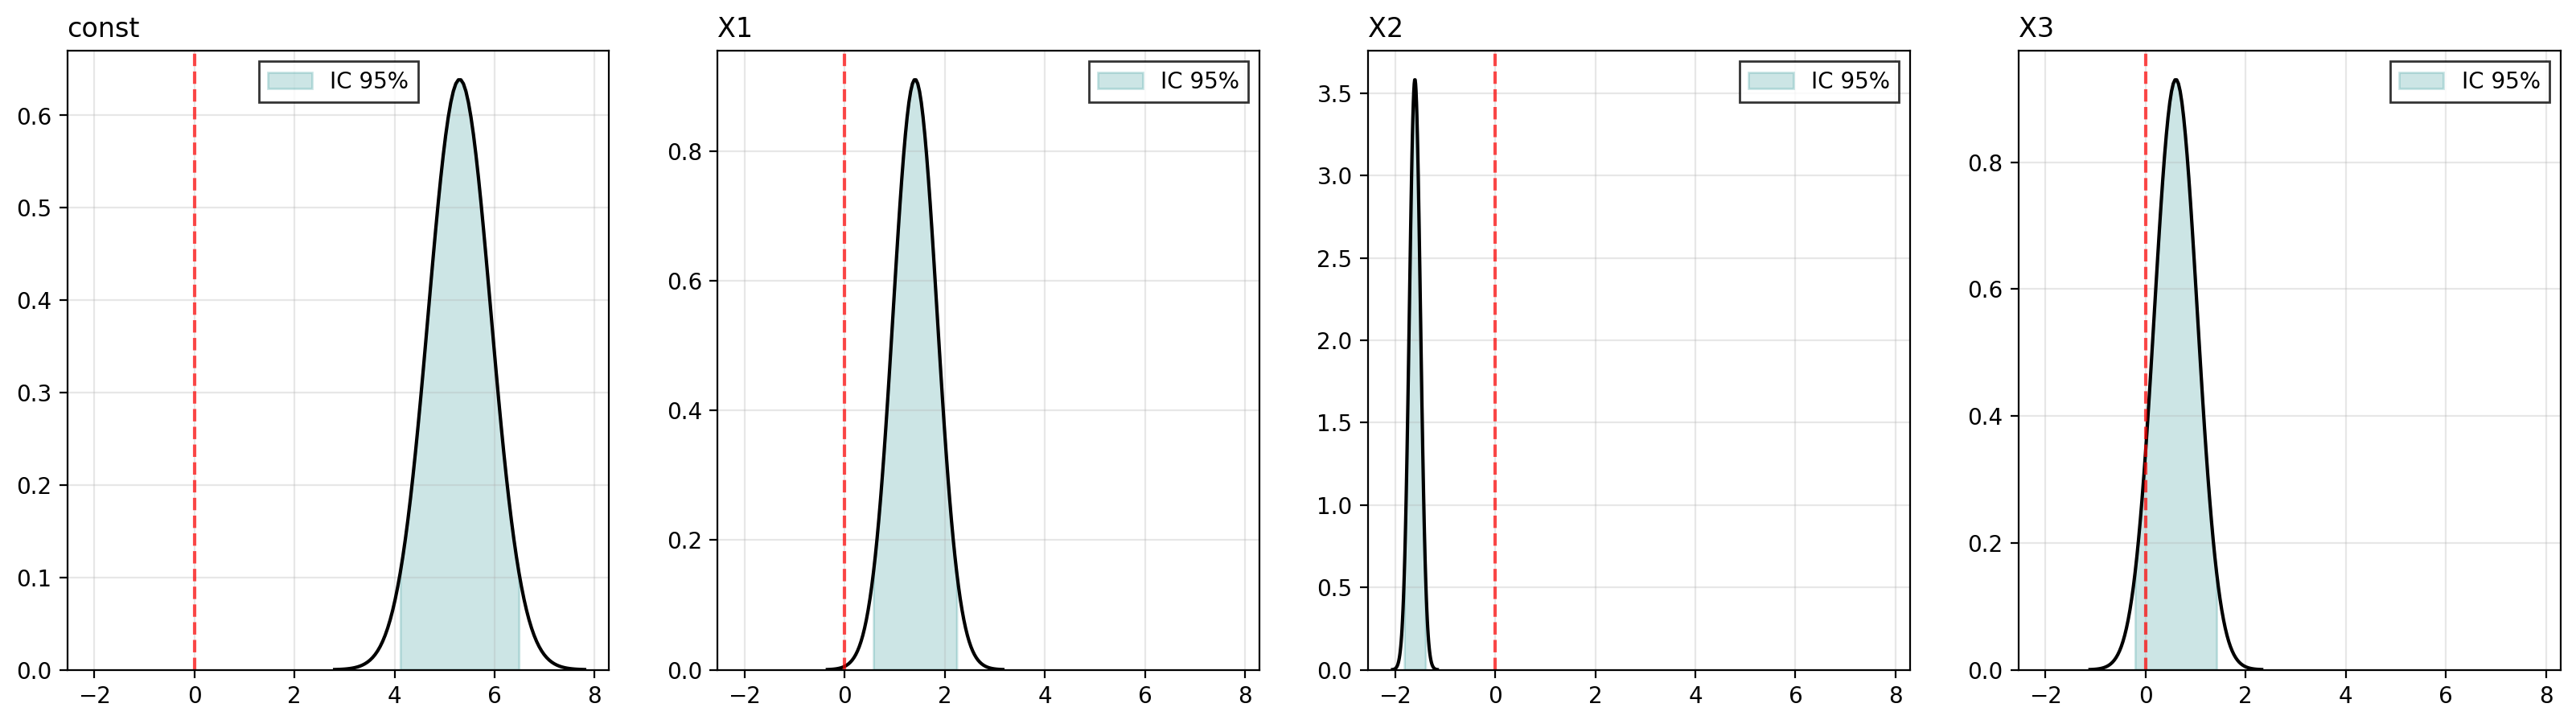

In [15]:
# Criando a figura e os subplots
fig, axs = plt.subplots(1, len(estimadores_regressao_multivariada), figsize=(20, 5),sharex=True)

# Iterando pelos estimadores e subplots
for i, (name, row) in enumerate(estimadores_regressao_multivariada.iterrows()):
    coef = row['Coeficiente']
    se = row['SE']
    
    # Criando uma distribuição normal para o coeficiente
    x = np.linspace(coef - 4 * se, coef + 4 * se, 100)
    y = stats.norm.pdf(x, loc=coef, scale=se)
    
    # Intervalo de confiança de 95%
    ci_lower = coef - 1.96 * se
    ci_upper = coef + 1.96 * se

    # Plotando no subplot correspondente
    axs[i].plot(x, y,color='k')
    axs[i].fill_between(x, y, where=(x >= ci_lower) & (x <= ci_upper), color='teal', alpha=0.2, label='IC 95%')  # Região do IC
    axs[i].axvline(0, color='red', linestyle='--', alpha=0.7)
    axs[i].set_title(f'{name}', loc='left')
    axs[i].set_ylim(0,)
    axs[i].grid(alpha=0.3)
    axs[i].legend(fancybox=False, edgecolor='k')

plt.show()

Perceba agora como o 0 está dentro do intervalo de confiança para $X_3$. Essa é a interpretação gráfica para o *p-value* associado a esta variável: não temos confiança o suficiente de que $\beta_3$ será diferente de zero e, portanto, não esteja relacionado a resposta $y$

### Análise dos modelos na regressão multivariada

In [16]:
# Métricas do modelo multivariado
pd.DataFrame({'Métrica': [modelo_multivariavel.rsquared,np.sqrt(modelo_multivariavel.mse_resid)]},index=['R2','RSE'])

,Métrica
R2,0.835416
RSE,3.036624


> Perceba que todas as métricas do modelo multivariado superam qualquer métrica de qualquer modelo simples.

Por fim, agora irei analisar o que acontece com o modelo de regressão multivariado que **não considera** a variável $X_3$

## Regressão linear multivariada com seleção de variáveis

In [17]:
X_vies = sm.add_constant(data[['X1', 'X2']])
modelo_multivariavel = sm.OLS(data['y'], X_vies).fit()

# Extraindo estatísticas dos coeficientes
estimadores_regressao_multivariada = pd.DataFrame({
    'Coeficiente': modelo_multivariavel.params,
    'SE': modelo_multivariavel.bse,
    't-statistic': modelo_multivariavel.tvalues,
    'p-value': modelo_multivariavel.pvalues
})

estimadores_regressao_multivariada

,Coeficiente,SE,t-statistic,p-value
const,5.301201,0.625870,8.470132,5.627636e-15
X1,2.015984,0.073201,27.540279,1.808881e-69
X2,-1.613720,0.111380,-14.488427,7.323561e-33


Note como as estimativas para os coeficientes mudaram. Além disso, perceba que o erro cometido por $\hat\beta_1$ diminuiu drasticamente, e isso custou um incremento negligente no erro de $\hat\beta_2$, assim como o intervalo de confiança para esses estimadores que ficou mais estreito.

# Conclusão
As regressões lineares simples mostram que:
- Tanto $X_1$ quanto $X_2$ apresentam coeficientes significativos, com *p-values* baixos, evidenciando a relação direta com $y$.
- $X_3$ também parece significativo em uma regressão simples devido à sua correlação com $X_1$ (correlação espúria).

Na regressão multivariada:
- $X_3$ não é mais significativo, com um *p-value* alto, indicando que sua relação com $y$ era espúria.
- $X_1$ e $X_2$ continuam significativos, validando sua influência direta em $y$.

A análise destaca a importância de considerar múltiplos preditores simultaneamente para evitar conclusões enganosas derivadas de correlações espúrias.